# Supervised Learning: Logistic Regression, KNN, and SVN

## Imports

In [1]:
# Import dependencies
import pandas as pd
import numpy as np

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import make_pipeline

from imblearn.over_sampling import SMOTE

## Read in train dataset

In [2]:
# Load data from excel
api_df = pd.read_excel("../../data/processed/train_essentials.xlsx")
api_df.head()

,is_pii,is_fii,NRI score,authentication_processed,usage_base_processed,AI & Data Science,Business & Technology,Environment & Weather,Finance & Banking,GeoInformatics & Navigation,...,content-type,set-cookie,access-control-allow-origin,server,x-powered-by,x-aspnet-version,x-ratelimit-limit,metadata_fields_count,parameters_count,Risk_Label
0,True,False,77.850013,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,2,2,Low
1,True,False,77.850013,1,2,0,0,0,0,0,...,0,0,0,1,0,0,0,6,1,Low
2,False,False,76.479613,1,2,0,1,0,0,0,...,0,0,0,1,0,0,0,3,1,Medium
3,True,False,76.479613,1,2,0,0,0,0,0,...,1,0,0,0,0,0,0,5,0,Low
4,True,False,77.850013,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,2,3,Low


In [3]:
api_df.shape

(1316, 53)

In [4]:
# X, y split
X_train, y_train = api_df.drop(columns=["Risk_Label"]), api_df["Risk_Label"]

In [5]:
y_train.value_counts()

Medium    661
Low       651
High        4
Name: Risk_Label, dtype: int64

In [6]:
# Smote function
def create_smote(X, y, k_neighbors):
    oversample = SMOTE(k_neighbors = k_neighbors)
    X, y = oversample.fit_resample(X, y)
    return X, y

In [7]:
# Balance training data
X_train, y_train = create_smote(X_train, y_train, 2)

# Helper Code

In [8]:
results = {}
scoring_metric = ["accuracy", "f1_macro", "recall_macro"]

In [9]:
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

# Baseline Performance

### Dummy Classifier Model

In [10]:
model_dummy = DummyClassifier(strategy="stratified", random_state=42)
results["Dummy"] = mean_std_cross_val_scores(
    model_dummy, X_train, y_train, return_train_score=True, scoring=scoring_metric
)
pd.DataFrame(results)

,Dummy
fit_time,0.004 (+/- 0.003)
score_time,0.028 (+/- 0.036)
test_accuracy,0.342 (+/- 0.019)
train_accuracy,0.331 (+/- 0.010)
test_f1_macro,0.342 (+/- 0.019)
train_f1_macro,0.331 (+/- 0.010)
test_recall_macro,0.342 (+/- 0.019)
train_recall_macro,0.331 (+/- 0.010)


### KNN Classifier Model

In [11]:
pipe_knn = make_pipeline(StandardScaler(), KNeighborsClassifier())
results["KNN"] = mean_std_cross_val_scores(
    pipe_knn, X_train, y_train, return_train_score=True, scoring=scoring_metric
)
pd.DataFrame(results)

,Dummy,KNN
fit_time,0.004 (+/- 0.003),0.010 (+/- 0.001)
score_time,0.028 (+/- 0.036),0.033 (+/- 0.017)
test_accuracy,0.342 (+/- 0.019),0.905 (+/- 0.008)
train_accuracy,0.331 (+/- 0.010),0.945 (+/- 0.004)
test_f1_macro,0.342 (+/- 0.019),0.905 (+/- 0.008)
train_f1_macro,0.331 (+/- 0.010),0.945 (+/- 0.004)
test_recall_macro,0.342 (+/- 0.019),0.905 (+/- 0.008)
train_recall_macro,0.331 (+/- 0.010),0.945 (+/- 0.004)


### SVM Classifier Model

In [12]:
pipe_svm = make_pipeline(StandardScaler(), SVC(gamma=0.01))
results["SVM"] = mean_std_cross_val_scores(
    pipe_svm, X_train, y_train, return_train_score=True, scoring=scoring_metric
)
pd.DataFrame(results)

,Dummy,KNN,SVM
fit_time,0.004 (+/- 0.003),0.010 (+/- 0.001),0.046 (+/- 0.023)
score_time,0.028 (+/- 0.036),0.033 (+/- 0.017),0.032 (+/- 0.004)
test_accuracy,0.342 (+/- 0.019),0.905 (+/- 0.008),0.980 (+/- 0.006)
train_accuracy,0.331 (+/- 0.010),0.945 (+/- 0.004),0.989 (+/- 0.003)
test_f1_macro,0.342 (+/- 0.019),0.905 (+/- 0.008),0.980 (+/- 0.006)
train_f1_macro,0.331 (+/- 0.010),0.945 (+/- 0.004),0.989 (+/- 0.003)
test_recall_macro,0.342 (+/- 0.019),0.905 (+/- 0.008),0.980 (+/- 0.006)
train_recall_macro,0.331 (+/- 0.010),0.945 (+/- 0.004),0.989 (+/- 0.003)


### Logistic Regression Classifier Model

In [13]:
pipe_lr = make_pipeline(StandardScaler(), LogisticRegression())
results["LR"] = mean_std_cross_val_scores(
    pipe_lr, X_train, y_train, return_train_score=True, scoring=scoring_metric
)
pd.DataFrame(results)

,Dummy,KNN,SVM,LR
fit_time,0.004 (+/- 0.003),0.010 (+/- 0.001),0.046 (+/- 0.023),0.037 (+/- 0.011)
score_time,0.028 (+/- 0.036),0.033 (+/- 0.017),0.032 (+/- 0.004),0.007 (+/- 0.004)
test_accuracy,0.342 (+/- 0.019),0.905 (+/- 0.008),0.980 (+/- 0.006),0.995 (+/- 0.003)
train_accuracy,0.331 (+/- 0.010),0.945 (+/- 0.004),0.989 (+/- 0.003),0.999 (+/- 0.000)
test_f1_macro,0.342 (+/- 0.019),0.905 (+/- 0.008),0.980 (+/- 0.006),0.995 (+/- 0.003)
train_f1_macro,0.331 (+/- 0.010),0.945 (+/- 0.004),0.989 (+/- 0.003),0.999 (+/- 0.000)
test_recall_macro,0.342 (+/- 0.019),0.905 (+/- 0.008),0.980 (+/- 0.006),0.995 (+/- 0.003)
train_recall_macro,0.331 (+/- 0.010),0.945 (+/- 0.004),0.989 (+/- 0.003),0.999 (+/- 0.000)


## Hyperparameter Optimization

### Hyperparameter search for KNN

In [14]:
results_dict = {
    "n_neighbors": [],
    "mean_train_score": [],
    "mean_cv_score": [],
    "std_cv_score": [],
    "std_train_score": [],
}
param_grid = {"n_neighbors": np.arange(5, 500, 5)}

for k in param_grid["n_neighbors"]:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_validate(knn, X_train, y_train, return_train_score=True)
    results_dict["n_neighbors"].append(k)

    results_dict["mean_cv_score"].append(np.mean(scores["test_score"]))
    results_dict["mean_train_score"].append(np.mean(scores["train_score"]))
    results_dict["std_cv_score"].append(scores["test_score"].std())
    results_dict["std_train_score"].append(scores["train_score"].std()) 

results_df = pd.DataFrame(results_dict)

<AxesSubplot:xlabel='n_neighbors'>

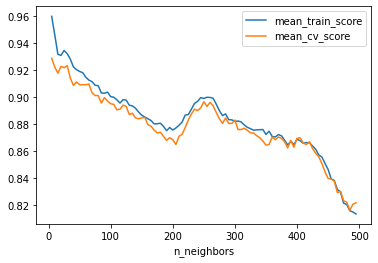

In [15]:
results_df.plot(x="n_neighbors", y=["mean_train_score", "mean_cv_score"])

In [16]:
results_df["train_cv_diff"] = results_df["mean_train_score"] - results_df["mean_cv_score"] 
results_df.head(20)

,n_neighbors,mean_train_score,mean_cv_score,std_cv_score,std_train_score,train_cv_diff
0,5,0.960035,0.928882,0.016890,0.003205,0.031153
1,10,0.946293,0.922329,0.011505,0.005858,0.023964
2,15,0.931796,0.917798,0.007622,0.003041,0.013998
3,20,0.931039,0.922839,0.006931,0.005690,0.008200
4,25,0.934694,0.921829,0.011651,0.004947,0.012865
5,30,0.932299,0.923351,0.008505,0.004510,0.008949
6,35,0.928265,0.914274,0.009278,0.002741,0.013992
7,40,0.922467,0.908726,0.013638,0.004583,0.013741
8,45,0.920449,0.911251,0.007814,0.003267,0.009198
9,50,0.919061,0.909230,0.009946,0.003460,0.009832


### Hyperparameter search for LogisticRegression

In [17]:
param_grid = {"logisticregression__C": [100, 10, 1.0, 0.1, 0.01],
             "logisticregression__solver": ['newton-cg', 'lbfgs', 'liblinear']}

grid_search = GridSearchCV(
    pipe_lr, param_grid, cv=20, n_jobs=-1, return_train_score=True
)
results_gs = grid_search.fit(X_train, y_train)

/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_ite

In [18]:
grid_search.best_score_

0.9954646464646466

In [19]:
grid_search.best_params_

{'logisticregression__C': 1.0, 'logisticregression__solver': 'newton-cg'}

## Performance of Optimized Models

### KNN classifier with n_neighbors=20

In [20]:
k = 20
pipe_knn = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=k))
results["KNN_tuned"] = mean_std_cross_val_scores(
    pipe_knn, X_train, y_train, return_train_score=True, scoring=scoring_metric
)
pd.DataFrame(results)

,Dummy,KNN,SVM,LR,KNN_tuned
fit_time,0.004 (+/- 0.003),0.010 (+/- 0.001),0.046 (+/- 0.023),0.037 (+/- 0.011),0.015 (+/- 0.007)
score_time,0.028 (+/- 0.036),0.033 (+/- 0.017),0.032 (+/- 0.004),0.007 (+/- 0.004),0.061 (+/- 0.057)
test_accuracy,0.342 (+/- 0.019),0.905 (+/- 0.008),0.980 (+/- 0.006),0.995 (+/- 0.003),0.853 (+/- 0.022)
train_accuracy,0.331 (+/- 0.010),0.945 (+/- 0.004),0.989 (+/- 0.003),0.999 (+/- 0.000),0.878 (+/- 0.008)
test_f1_macro,0.342 (+/- 0.019),0.905 (+/- 0.008),0.980 (+/- 0.006),0.995 (+/- 0.003),0.852 (+/- 0.022)
train_f1_macro,0.331 (+/- 0.010),0.945 (+/- 0.004),0.989 (+/- 0.003),0.999 (+/- 0.000),0.877 (+/- 0.008)
test_recall_macro,0.342 (+/- 0.019),0.905 (+/- 0.008),0.980 (+/- 0.006),0.995 (+/- 0.003),0.853 (+/- 0.022)
train_recall_macro,0.331 (+/- 0.010),0.945 (+/- 0.004),0.989 (+/- 0.003),0.999 (+/- 0.000),0.878 (+/- 0.008)


### Logistic Regression Classifier Model

In [21]:
pipe_lr_tuned = make_pipeline(StandardScaler(), LogisticRegression(C=100.0, solver='liblinear'))
results["LR_tuned"] = mean_std_cross_val_scores(
    pipe_lr_tuned, X_train, y_train, return_train_score=True, scoring=scoring_metric
)
pd.DataFrame(results)

,Dummy,KNN,SVM,LR,KNN_tuned,LR_tuned
fit_time,0.004 (+/- 0.003),0.010 (+/- 0.001),0.046 (+/- 0.023),0.037 (+/- 0.011),0.015 (+/- 0.007),0.086 (+/- 0.028)
score_time,0.028 (+/- 0.036),0.033 (+/- 0.017),0.032 (+/- 0.004),0.007 (+/- 0.004),0.061 (+/- 0.057),0.009 (+/- 0.002)
test_accuracy,0.342 (+/- 0.019),0.905 (+/- 0.008),0.980 (+/- 0.006),0.995 (+/- 0.003),0.853 (+/- 0.022),0.994 (+/- 0.004)
train_accuracy,0.331 (+/- 0.010),0.945 (+/- 0.004),0.989 (+/- 0.003),0.999 (+/- 0.000),0.878 (+/- 0.008),0.998 (+/- 0.001)
test_f1_macro,0.342 (+/- 0.019),0.905 (+/- 0.008),0.980 (+/- 0.006),0.995 (+/- 0.003),0.852 (+/- 0.022),0.994 (+/- 0.004)
train_f1_macro,0.331 (+/- 0.010),0.945 (+/- 0.004),0.989 (+/- 0.003),0.999 (+/- 0.000),0.877 (+/- 0.008),0.998 (+/- 0.001)
test_recall_macro,0.342 (+/- 0.019),0.905 (+/- 0.008),0.980 (+/- 0.006),0.995 (+/- 0.003),0.853 (+/- 0.022),0.994 (+/- 0.004)
train_recall_macro,0.331 (+/- 0.010),0.945 (+/- 0.004),0.989 (+/- 0.003),0.999 (+/- 0.000),0.878 (+/- 0.008),0.998 (+/- 0.001)
